<a href="https://colab.research.google.com/github/ogigo/Generative_Aedversial_Network/blob/main/Generate_anime_Faces_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
!mkdir -p ~/.kaggle

In [3]:
api_token = {"username":"kajolmaster","key":"dbb23ceaca2a39397c3e92d83fda1034"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:json.dump(api_token, file)

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download splcher/animefacedataset

100% 394M/395M [00:22<00:00, 22.5MB/s]
100% 395M/395M [00:22<00:00, 18.0MB/s]


In [ ]:
!unzip animefacedataset.zip

In [7]:
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.nn.functional as F
%matplotlib inline
import os
import glob
import shutil

In [8]:
!mkdir anime_faces

In [9]:
!mkdir /content/anime_faces/img

In [10]:
src_dir = "/content/images"
dst_dir = "/content/anime_faces/img"
for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):
    shutil.copy(jpgfile, dst_dir)

In [11]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder("/content/anime_faces", transform=T.Compose([T.Resize(image_size), 
                                                                T.CenterCrop(image_size),
                                                                T.ToTensor(),
                                                                T.Normalize(*stats)]))

In [12]:
!ls -a

 .    animefacedataset.zip   .config  'kaggle (3).json'
 ..   anime_faces	     images    sample_data


In [13]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [14]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

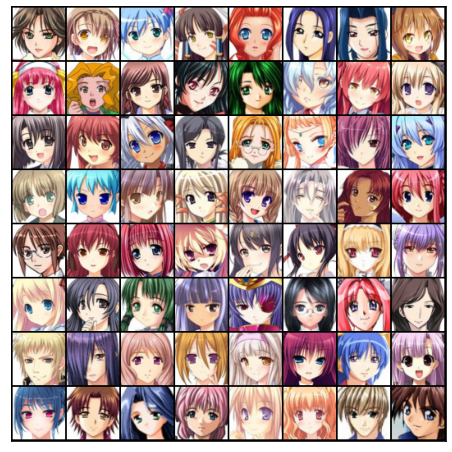

In [15]:
show_batch(train_dl)

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
train_dl = DeviceDataLoader(train_dl, device)

In [19]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [20]:
discriminator = to_device(discriminator, device)

In [21]:
latent_size = 128

In [22]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


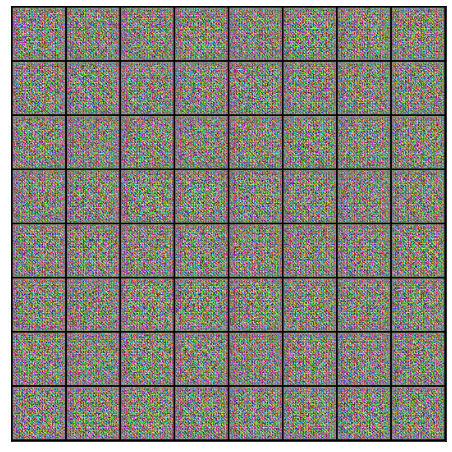

In [23]:
xb=torch.randn(batch_size,latent_size,1,1)
fake_images=generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [24]:
generator = to_device(generator, device)

In [25]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [26]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [27]:
def show_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [28]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

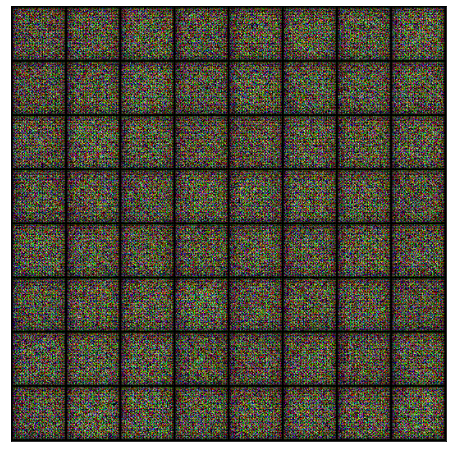

In [29]:
show_samples(0, fixed_latent)

In [30]:
def fit(epochs, lr, start_idx=1, show=False):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
    return losses_g, losses_d, real_scores, fake_scores

In [31]:
lr = 0.0002
epochs = 30

In [32]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/30], loss_g: 4.9262, loss_d: 0.2016, real_score: 0.8970, fake_score: 0.0751


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/30], loss_g: 3.5114, loss_d: 0.3848, real_score: 0.8350, fake_score: 0.1637


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/30], loss_g: 7.0193, loss_d: 0.4576, real_score: 0.6927, fake_score: 0.0042


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/30], loss_g: 5.1046, loss_d: 0.1667, real_score: 0.9121, fake_score: 0.0573


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/30], loss_g: 7.2754, loss_d: 0.0496, real_score: 0.9666, fake_score: 0.0108


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/30], loss_g: 5.5242, loss_d: 0.4551, real_score: 0.7025, fake_score: 0.0039


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/30], loss_g: 9.5588, loss_d: 0.3262, real_score: 0.7977, fake_score: 0.0000


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/30], loss_g: 6.1315, loss_d: 0.1005, real_score: 0.9342, fake_score: 0.0237


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/30], loss_g: 6.0464, loss_d: 0.1041, real_score: 0.9718, fake_score: 0.0655


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/30], loss_g: 5.2935, loss_d: 0.0101, real_score: 0.9922, fake_score: 0.0021


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/30], loss_g: 7.9014, loss_d: 1.7195, real_score: 0.3715, fake_score: 0.0000


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/30], loss_g: 3.7632, loss_d: 0.2003, real_score: 0.8905, fake_score: 0.0623


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/30], loss_g: 7.6472, loss_d: 0.2640, real_score: 0.9771, fake_score: 0.1934


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/30], loss_g: 4.9155, loss_d: 0.4149, real_score: 0.7226, fake_score: 0.0020


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/30], loss_g: 14.4788, loss_d: 2.0998, real_score: 0.9999, fake_score: 0.7912


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/30], loss_g: 2.7353, loss_d: 1.0446, real_score: 0.6408, fake_score: 0.0764


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/30], loss_g: 4.2741, loss_d: 0.1326, real_score: 0.9491, fake_score: 0.0705


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/30], loss_g: 6.6923, loss_d: 0.2361, real_score: 0.9774, fake_score: 0.1756


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/30], loss_g: 6.4199, loss_d: 0.1264, real_score: 0.9942, fake_score: 0.1046


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/30], loss_g: 5.1447, loss_d: 0.1235, real_score: 0.9686, fake_score: 0.0822


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/30], loss_g: 4.7569, loss_d: 0.1325, real_score: 0.9642, fake_score: 0.0834


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/30], loss_g: 12.5122, loss_d: 1.9371, real_score: 0.9999, fake_score: 0.7475


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/30], loss_g: 5.4442, loss_d: 0.6444, real_score: 0.9282, fake_score: 0.3540


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/30], loss_g: 5.0202, loss_d: 0.1421, real_score: 0.9728, fake_score: 0.0962


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/30], loss_g: 3.7390, loss_d: 0.2832, real_score: 0.8240, fake_score: 0.0432


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [26/30], loss_g: 6.0063, loss_d: 0.1371, real_score: 0.9912, fake_score: 0.1072


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [27/30], loss_g: 1.1050, loss_d: 2.5476, real_score: 0.1550, fake_score: 0.0001


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [28/30], loss_g: 4.7681, loss_d: 0.0793, real_score: 0.9564, fake_score: 0.0296


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [29/30], loss_g: 4.9856, loss_d: 0.0851, real_score: 0.9780, fake_score: 0.0574


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [30/30], loss_g: 6.5258, loss_d: 0.3804, real_score: 0.9983, fake_score: 0.2606


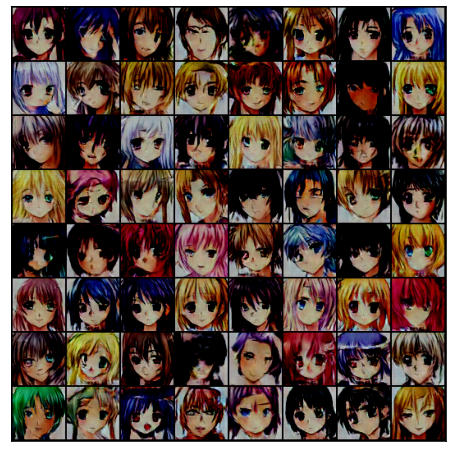

In [33]:
show_samples(0, fixed_latent)

In [34]:
losses_g, losses_d, real_scores, fake_scores = history

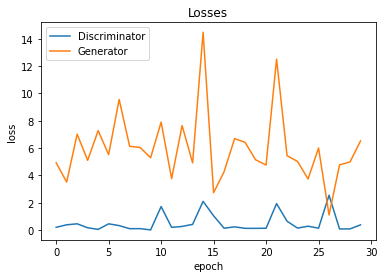

In [35]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

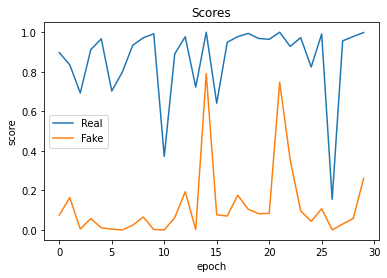

In [36]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');